In [10]:
import pandas as pd
import math
import random
import warnings

class dataLoader:
    def __init__(self, data_url, label):
        warnings.filterwarnings('ignore')
        pd.options.mode.chained_assignment = None
        if data_url.endswith('.csv'):
            self.data = pd.read_csv(data_url)
        elif data_url.endswith('.xlsx'):
            self.data = pd.read_excel(data_url)
        else:
            raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")
        
        self.label = label
        
        if self.label not in self.data.columns.tolist():
            raise Exception("label not in dataset")
        
    def detachedData(self, data):

        Y = data[self.label]

        X = data.drop(columns=[self.label])

        return X,Y

    def hold_out(self, train_per = 0.7, val_per = 0.3):        
        m = len(self.data)
        
        self.train_data = self.data.iloc[0: math.floor(train_per * m)] # 0-105 => 106 pt
            
        self.val_data = self.data.iloc[len(self.train_data) :]
        
        self.train_data.X, self.train_data.Y = self.detachedData(self.train_data)
        
        self.val_data.X, self.val_data.Y = self.detachedData(self.val_data)
        
    def kfold_split(self, K, shuffle=True, random_state=42):
        if shuffle:            
            indices = list(self.data.index)
            random.seed(random_state)
            random.shuffle(indices)
            self.data = self.data.iloc[indices].reset_index(drop=True)
            # chưa hiểu cách chạy self.data.iloc[indices].reset_index(drop=True)

        fold_sizes = np.full(K, len(self.data) // K, dtype=int)
        fold_sizes[: len(self.data) % K] += 1

        current = 0
        folds = []
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            folds.append(self.data.iloc[start:stop])
            current = stop

        return folds
    
    def K_fold(self, K = 5):
        folds = self.kfold_split(K, shuffle=True)  # Tách từng fold cho K

        self.val_data = []
        self.train_data = []

        for i in range(K):
            self.val_data.append(folds[i])  # Chọn fold[i] làm tập validation

            train_j = pd.DataFrame()  # Khởi tạo lại tập huấn luyện trong mỗi vòng lặp
            for j in range(K):
                if i != j:
                    train_j = pd.concat([train_j, folds[j]], axis=0, ignore_index=True)
            self.train_data.append(train_j)  # Thêm train_j vào self.train_data

        for i in range(len(self.train_data)):
            self.train_data[i].X, self.train_data[i].Y = self.detachedData(self.train_data[i])
            
            self.val_data[i].X, self.val_data[i].Y = self.detachedData(self.val_data[i])
            
    def LOO(self):
        self.K_fold(len(self.data))
        

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluate:
    @staticmethod
    def loss(y_true, y_pred):
        return abs(y_true - y_pred) / len(y_true)
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        unique_labels = np.unique(y_true)
        matrix = {label: {l: 0 for l in unique_labels} for label in unique_labels}

        for true, pred in zip(y_true, y_pred):
            matrix[true][pred] += 1

        # Convert to DataFrame
        matrix_df = pd.DataFrame(matrix).T.fillna(0)
        
        return matrix_df

    @staticmethod
    def classification_report(y_true, y_pred):
        cm = Evaluate.confusion_matrix(y_true, y_pred)
        report = {}
        
        for label in cm.index:
            TP = cm.loc[label, label]
            FP = cm[label].sum() - TP
            FN = cm.loc[label].sum() - TP
            TN = cm.sum().sum() - (TP + FP + FN)
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
            tpr = recall  # True Positive Rate is the same as Recall
            
            report[label] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'fpr': fpr,
                'tpr': tpr
            }

        # Plot the heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=cm.columns, yticklabels=cm.index)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return report

In [12]:
# SỬ DỤNG MÔ HÌNH HỒI QUY TUYẾN TÍNH DỰ ĐOÁN
class Linear_Regression:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    # KHỞI TẠO HÀM TRIANNING TÍNH HỆ SỐ BẰNG PHƯƠNG TRÌNH CHUẨN
    def fit(self):
        # Thêm cột 1 vào X để tính toán hệ số chặn b
        X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        # Tính ma trận chuyển vị của X
        XT = X.T
        # Tính XTX = X^T * X
        XTX = np.dot(XT, X)
        # Tính (XTX)^(-1)
        inv_XTX = np.linalg.inv(XTX)
        # Tính (XTX)^(-1) * X^T
        inv_XTX_XT = np.dot(inv_XTX, XT)
        # Tính kết quả cuối cùng (X^TX)^(-1) * X^T * Y
        beta=np.dot(inv_XTX_XT, self.Y)
        # gán giá trị số chặn và hệ số
        self.intercept = beta[0]
        self.coef = beta[1::]
            
    def predict(self,X_val):
        return np.dot(X_val,self.coef) + self.intercept

In [13]:
# chương 6
class Logistic_Regression:
    def __init__(self, X_train, Y_train):
        self.X = X_train
        self.Y = Y_train
        
    def sigmoid(self,x):
        return float(1)/(1 + np.exp(-x))
    
    def fit(self):
        # tính toán hệ số bằng hồi quy tuyến tính
        self.linear = Linear_Regression(self.X,self.Y) 
        self.linear.fit()
        
    def predict(self, X_test, Y_test):
        # dự đoán bằng công thức sigmoid
        y = self.linear.predict(X_test)
        P = self.sigmoid(y)
        Y_pred = np.where(P > 0.5, 1, 0)
        
        # Đánh giá mô hình
        conf_matrix = Evaluate.confusion_matrix(Y_test, Y_pred)
        report = Evaluate.classification_report(Y_test, Y_pred)

        # Tính độ chính xác
        accuracy = np.mean(Y_pred == Y_test)
        
        print(f"Accuracy: {accuracy}") # Độ chính xác dựa vào số mẫu đã kiểm tra
        print("Classification Report:")
        for label, metrics in report.items():
            print(f"Class {label}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        
        return(Y_pred)
        

Hệ số: [0.0132043  0.00633224 0.03466563]
Số chặn b: -0.958414912098714



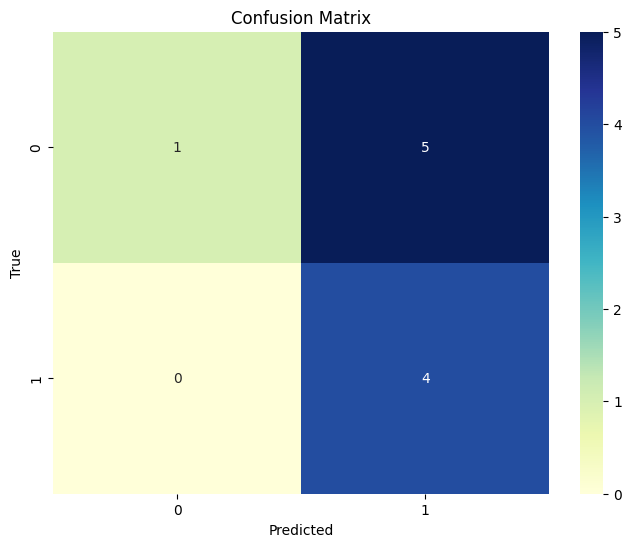

Accuracy: 0.5
Classification Report:
Class 0:
  precision: 1.0
  recall: 0.16666666666666666
  f1_score: 0.2857142857142857
  fpr: 0.0
  tpr: 0.16666666666666666
Class 1:
  precision: 0.4444444444444444
  recall: 1.0
  f1_score: 0.6153846153846153
  fpr: 0.8333333333333334
  tpr: 1.0
<class 'pandas.core.frame.DataFrame'>
   Y_acutal  Y_predict
0         0          1
1         1          1
2         0          1
3         0          1
4         0          1
5         1          1
6         0          0
7         1          1
8         0          1
9         1          1


In [14]:
import numpy as np
import pandas as pd

# đọc dataset
df = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap6.xlsx','Response')
X, Y = df.detachedData(df.data)
log_reg = Logistic_Regression(X,Y)
log_reg.fit()
print(f'Hệ số: {log_reg.linear.coef}\nSố chặn b: {log_reg.linear.intercept}\n')

Y_pred = log_reg.predict(X,Y)
Y_actual = Y.tolist()
data_rs2show = {'Y_acutal': Y_actual, 'Y_predict': Y_pred}

rs2show = pd.DataFrame(data_rs2show)
print(type(rs2show))
print(rs2show)